In [2]:
import numpy as np
from pprint import pprint
import sys, os
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('utils')
from SetupConnections import *
from NeuronCircuit import Circuit
from analysis_utils import baks
from neuron import h

font = {'family' : 'sans-serif',
        'sans-serif': 'Arial',
        'style': 'normal',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# f = open('../../mpl_rcparams.pkl', 'rb')
# file = pkl.load(f)
# file.pop('datapath')
# file.pop('examples.directory')
# file.pop('savefig.frameon')
# file.pop('text.latex.unicode')
# file.pop('verbose.fileo')
# file.pop('verbose.level')
# #file.pop('image.cmap')

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [3]:

delay = 500.
dt = 0.1

ar = Arena('params/arenaparams.yaml')
ar.generate_population_firing_rates()
ar.generate_cue_firing_rates('LEC', 1.0)

cued = True
ar.generate_spike_times('MF', dt=dt, delay=delay)
ar.generate_spike_times('MEC', dt=dt, delay=delay)
ar.generate_spike_times('LEC', dt=dt, delay=delay, cued=cued)
ar.generate_spike_times('Background', dt=dt, delay=delay)


[23  1 25  0  5 13 26 10 28 17  3  8 12 15  7  9 16 11  4 14 29 19 22 21
 20  2 24  6 27 18]


Text(0.5, 1.0, 'MEC: 947')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


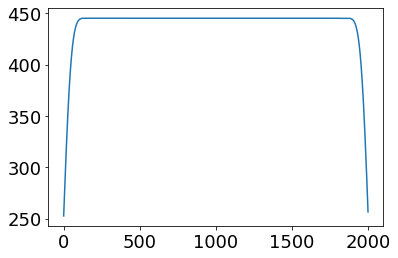

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


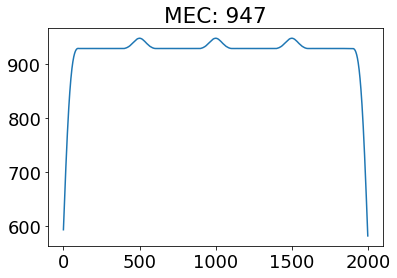

In [4]:
from copy import deepcopy

total_fr = []
plt.figure()
for i in range(400):
    fr = deepcopy(ar.cell_information['MF']['cell info'][i]['firing rate'])
    if i == 0:
        total_fr = fr
    else:
        total_fr += fr
plt.plot(total_fr)


   
total_fr = []
for i in range(200):
    fr = deepcopy(ar.cell_information['MEC']['cell info'][i]['firing rate'])
    if i == 0:
        total_fr = fr
    else:
        total_fr += fr
        
plt.figure()
plt.plot(total_fr)
plt.title('MEC: %i' % np.max(total_fr))






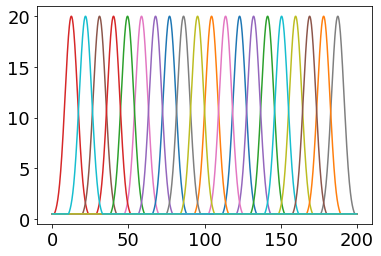

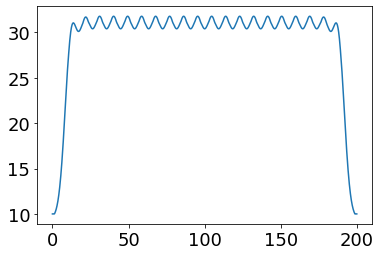

In [5]:
fr = ar.cell_information['LEC']['cell info'][0]['firing rate']

edge = 12.5
nlaps = 20
lp    = 1

arena_map  = np.arange(0, 200,step=0.1)
cued_positions  = np.linspace(edge, 200-edge, nlaps*lp)
random_cue_locs = np.arange(len(cued_positions))
np.random.shuffle(random_cue_locs)


#random_cue_locs = [1, 22, 16, 21, 17, 10, 23, 13,  3,  8, 15,  7,  9,  0,  5, 12, 11,  4, 14, 24, 19, 20,  2,  6, 18]

frs_all = []
for i in range(nlaps):
    random_position = cued_positions[random_cue_locs[i]]
    to_roll = int( ( 100. - random_position) / 0.1 )
    fr_rolled = np.roll(fr, to_roll)
    frs_all.append(fr_rolled)

frs_all = np.asarray(frs_all)

plt.figure()
for i in range(nlaps):
    plt.plot(arena_map, frs_all[i])
    
plt.figure()
plt.plot(arena_map,np.sum(frs_all, axis=0))



In [6]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 20


frac place 0.8


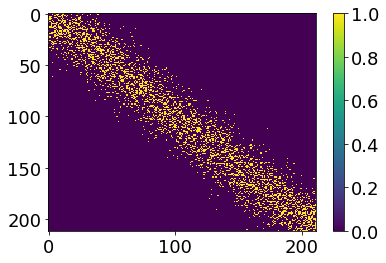

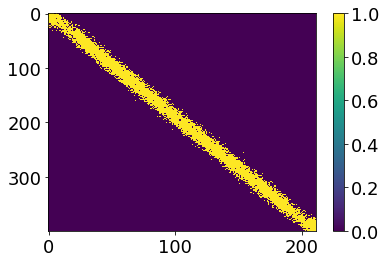

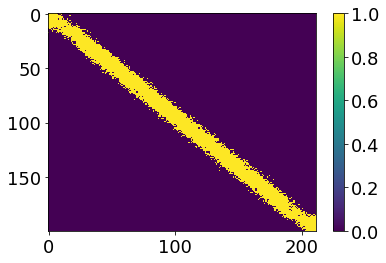

4980
6432
24720


In [7]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram('params/circuitparams.yaml', place_information)
diagram.generate_internal_connectivity()


place_ids = diagram.place_information[0]['place']


external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)
diagram.generate_septal_connectivity()

plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[101][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

print(np.sum(diagram.internal_adj_matrices[0][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][1],axis=0).sum())



In [8]:
def pull_spike_times(population2info_dict):
    spike_times = []
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times.append(population2info_dict[gid]['spike times'])
    return spike_times

mf_spike_times  = pull_spike_times(ar.cell_information['MF']['cell info'])
mec_spike_times = pull_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = pull_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = pull_spike_times(ar.cell_information['Background']['cell info'])

In [47]:
circuit = Circuit('params/circuitparams.yaml', diagram.pop2id, diagram.external_pop2id)
circuit.build_cells()
circuit.build_internal_netcons(diagram.internal_adj_matrices)
circuit.build_external_netcons(100, diagram.external_adj_matrices[100], mf_spike_times)
circuit.build_external_netcons(101, diagram.external_adj_matrices[101], mec_spike_times)
circuit.build_external_netcons(102, diagram.external_adj_matrices[102], lec_spike_times)
circuit.build_external_netcons(103, diagram.external_adj_matrices[103], bk_spike_times)
#circuit.record_lfp([0,1])
#circuit.build_septal_netcons(diagram.septal_adj_matrices)

8


(73833.33333333334, 80500.0)

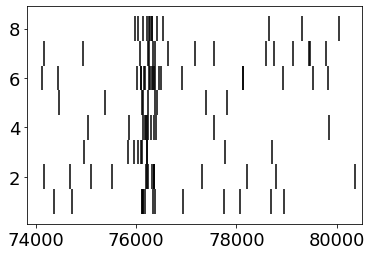

In [591]:
start  = time_for_single_lap * 11 + 500
finish = time_for_single_lap * 12 + 500


cue_cells = diagram.place_information[0]['not place']

for z in cue_cells[:1]:

    plt.figure()
    count = 0
    i = 0
    for nskeys in circuit.netstims[(102,0)].keys():
        if nskeys[1] == z:
            ns = circuit.netstims[(102,0)][(nskeys[0],nskeys[1])]
            count += len(ns)
            if len(ns) > 0:
                k = ns[0]
                plt.vlines(list(k[0]), i+0.5, i+1.5)
                i += 1
    print(count)

plt.xlim([start, finish])

    
    


In [48]:
import time

h.load_file("stdrun.hoc")

def get_population_voltages(c,pop_id):
    v_vecs = []
    for i in range(len(c.neurons[pop_id])):
        v_vec = h.Vector()
        try:
            v_vec.record(c.neurons[pop_id][i].axon(0.5)._ref_v)
        except:
            v_vec.record(c.neurons[pop_id][i].soma(0.5)._ref_v)
        v_vecs.append(v_vec)
    return v_vecs

exc_v_vecs     = get_population_voltages(circuit, 0)
#pvbc_v_vecs    = get_population_voltages(circuit, 1)
# aac_v_vecs   = get_population_voltages(2)
# bis_v_vecs   = get_population_voltages(3)
# olm_v_vecs   = get_population_voltages(4)
# isccr_v_vecs = get_population_voltages(5)
# iscck_v_vecs = get_population_voltages(6)

print('starting simulation..')
    
t_vec = h.Vector()  # Time stamp vector
t_vec.record(h._ref_t)

tic = time.time()

h.dt = 0.1
h.celsius = 37.
h.tstop =  time_for_single_lap * 20. + 500
h.finitialize(-65.0)
h.fadvance()
h.continuerun(h.tstop)

elapsed = time.time() - tic
print('that took %0.3f seconds' % elapsed)

starting simulation..
that took 7104.119 seconds


[16, 9, 14, 13, 7, 45, 0, 18, 24, 19, 1, 19, 9, 19, 6, 22, 17, 12, 45, 10, 4, 17, 28, 12, 15, 83, 81, 123, 116, 125, 32, 16, 74, 61, 92, 53, 53, 29, 109, 187, 64, 103, 165, 66, 32, 13, 37, 39, 31, 31, 59, 25, 38, 34, 41, 44, 24, 53, 87, 25, 15, 54, 137, 62, 145, 49, 94, 107, 127, 94, 128, 27, 224, 205, 136, 165, 147, 188, 55, 33, 46, 112, 29, 57, 45, 25, 57, 21, 19, 10, 83, 39, 27, 21, 109, 41, 34, 11, 65, 52, 68, 31, 12, 31, 24, 60, 54, 124, 127, 106, 92, 125, 32, 127, 65, 97, 162, 58, 139, 96, 173, 87, 160, 32, 43, 154, 115, 38, 41, 9, 57, 26, 32, 45, 76, 17, 44, 106, 36, 31, 28, 38, 35, 73, 13, 119, 4, 33, 89, 34, 76, 59, 31, 72, 23, 20, 85, 67, 37, 43, 37, 67, 38, 37, 19, 47, 47, 37, 61, 41, 28, 75, 87, 79, 49, 22, 107, 88, 47, 66, 140, 107, 151, 47, 179, 247, 152, 112, 196, 126, 5, 2, 9, 1, 2, 15, 79, 11, 15, 59, 6, 7, 71, 78, 52, 25, 77, 35, 22, 27, 41, 60]
[  0   1   1   2   2   4   4   5   6   6   7   7   9   9   9   9  10  10
  11  11  12  12  12  13  13  13  14  15  15  15  1

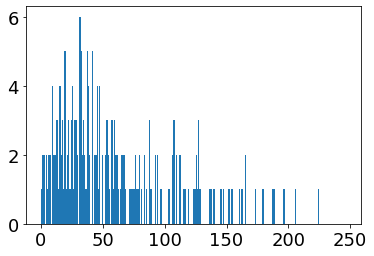

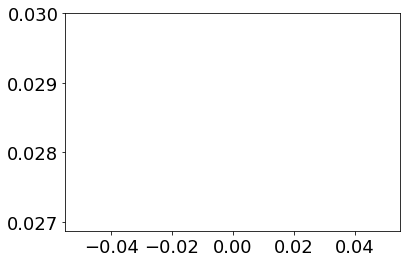

In [10]:
nplaces = len(place_ids)

# for i in range(55,65):
#     plt.figure()
#     plt.plot(np.asarray(t_vec), np.asarray(exc_v_vecs)[place_ids][i][:].T)
#     plt.ylim([-75,-30])
#     plt.show()
    
nspikes = []
ecells = circuit.neurons[0]
for pid in place_ids:
    spks = np.asarray(list(ecells[pid].spike_times))
    spks = spks[spks>500]
    nspikes.append(len(spks))
print(nspikes)
    
plt.figure()
plt.hist(nspikes, bins=np.arange(0,np.max(nspikes)))
print(np.sort(nspikes), nplaces)


low_spike_pos = []
for (i,nspk) in enumerate(nspikes):
    if nspk == 0:
        low_spike_pos.append(diagram.wiring_information['ca3pyr']['cell info'][place_ids[i]]['soma position'])
    
plt.figure()
plt.plot(low_spike_pos)

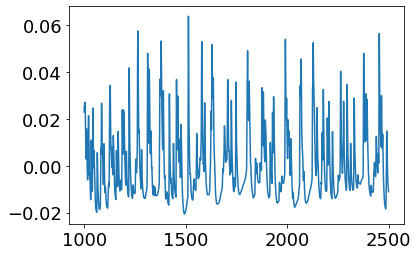

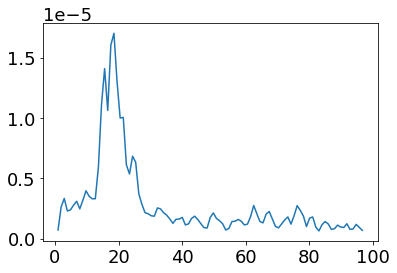

/mnt/d/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


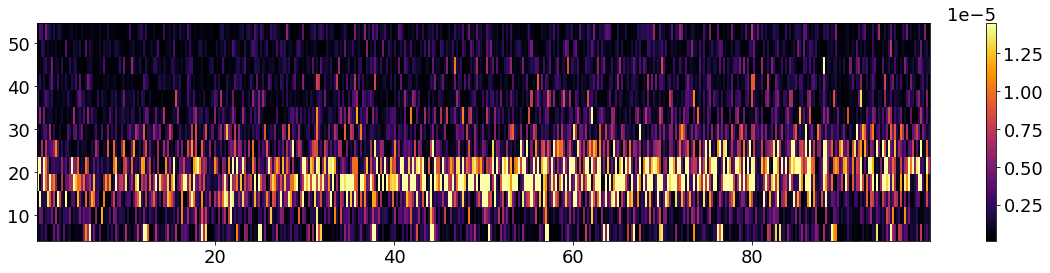

In [10]:
from analysis_utils import butter_bandpass_filter
from scipy.signal import welch, spectrogram

lfp = circuit.lfp
lfp_np = np.asarray([np.asarray(l, dtype='float32') for l in lfp], dtype='float32')
lfp_mean = lfp_np.mean(axis=0)

lfp_filtered = butter_bandpass_filter(lfp_mean, 2.0, 250.0, 2000., order=3)

start = np.where(np.asarray(t_vec) > time_for_single_lap*14+500)[0][0]
end   = np.where(np.asarray(t_vec) < time_for_single_lap*15+500)[0][-1]


plt.figure()
plt.plot(list(t_vec)[2000:5000], lfp_filtered[2000:5000])


f, p = welch(lfp_filtered[start:end], fs=2000., nperseg=2048)
plt.figure()
plt.plot(f[1:100], p[1:100])
plt.show()

lfp_f, lfp_t, lfp_S = spectrogram(lfp_mean[1000:end], fs=2000., nperseg=512)
fs, fe = np.where(lfp_f >= 2.0)[0][0], np.where(lfp_f <= 60)[0][-1]
lfp_S_reduced = lfp_S[fs:fe,:]
minn = np.percentile(lfp_S_reduced, 5.)
maxx = np.percentile(lfp_S_reduced, 95.)
plt.figure(figsize=(20,4))
plt.pcolormesh(lfp_t, lfp_f[fs:fe], lfp_S_reduced, vmin=minn, vmax=maxx, cmap='inferno')
plt.colorbar()
plt.show()

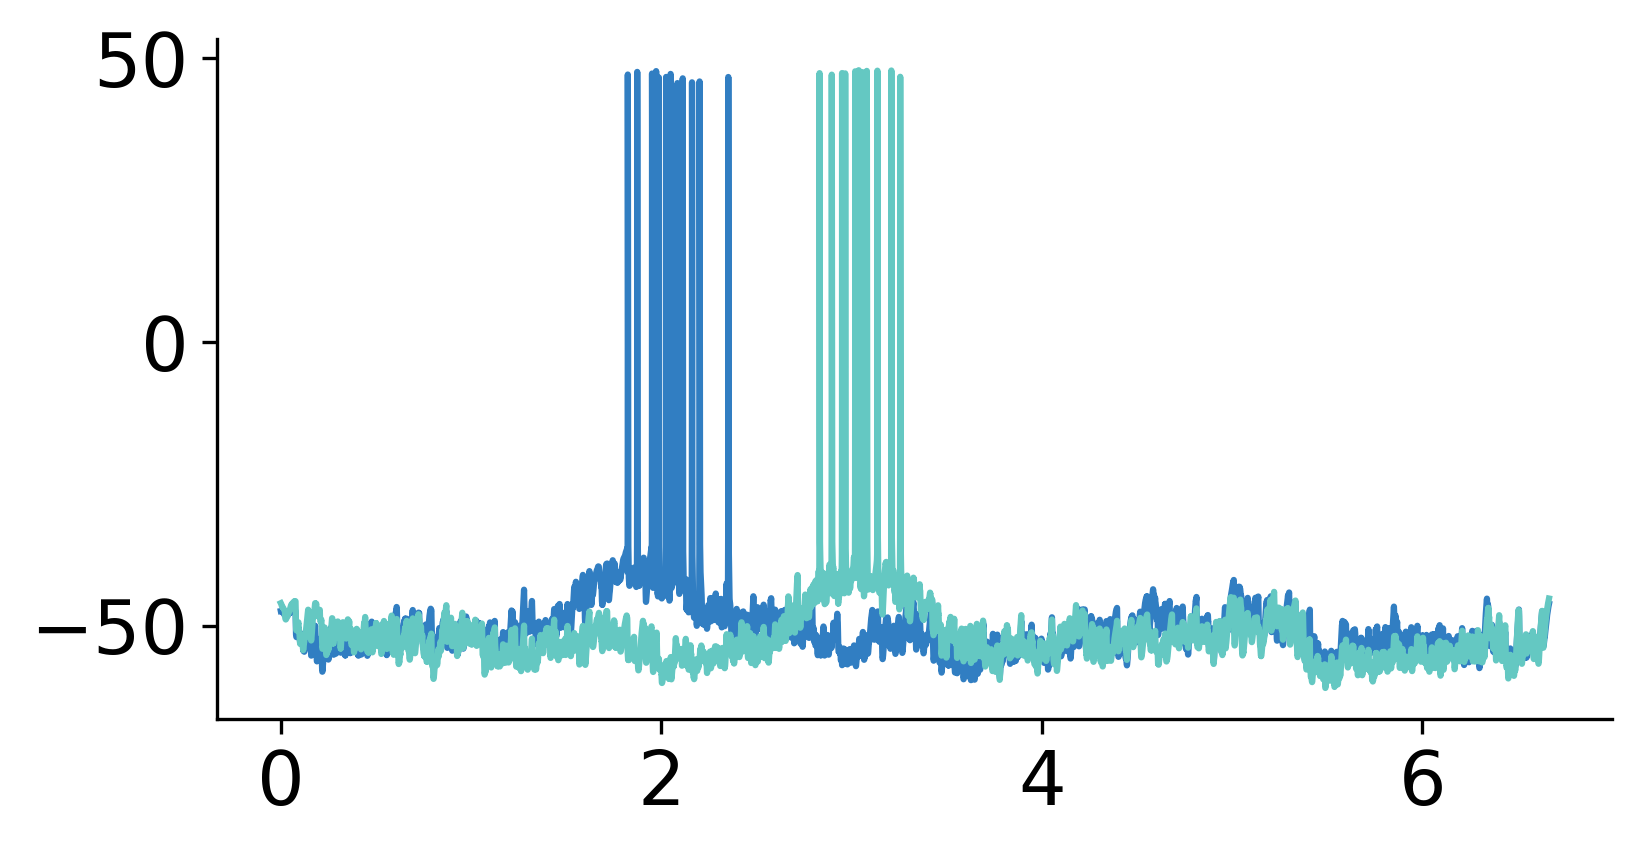

In [61]:
t_vec = np.asarray(t_vec)
s = np.where(t_vec > time_for_single_lap*19+500)[0][0]
e = np.where(t_vec < time_for_single_lap*20+500)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(6,3), dpi=300)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., list(exc_v_vecs[77])[s:e], color=(49/255., 126/255., 194/255.))
plt.plot( (t_vec[s:e]-t_vec[s])/1000., list(exc_v_vecs[119])[s:e], color=(100/255., 200/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

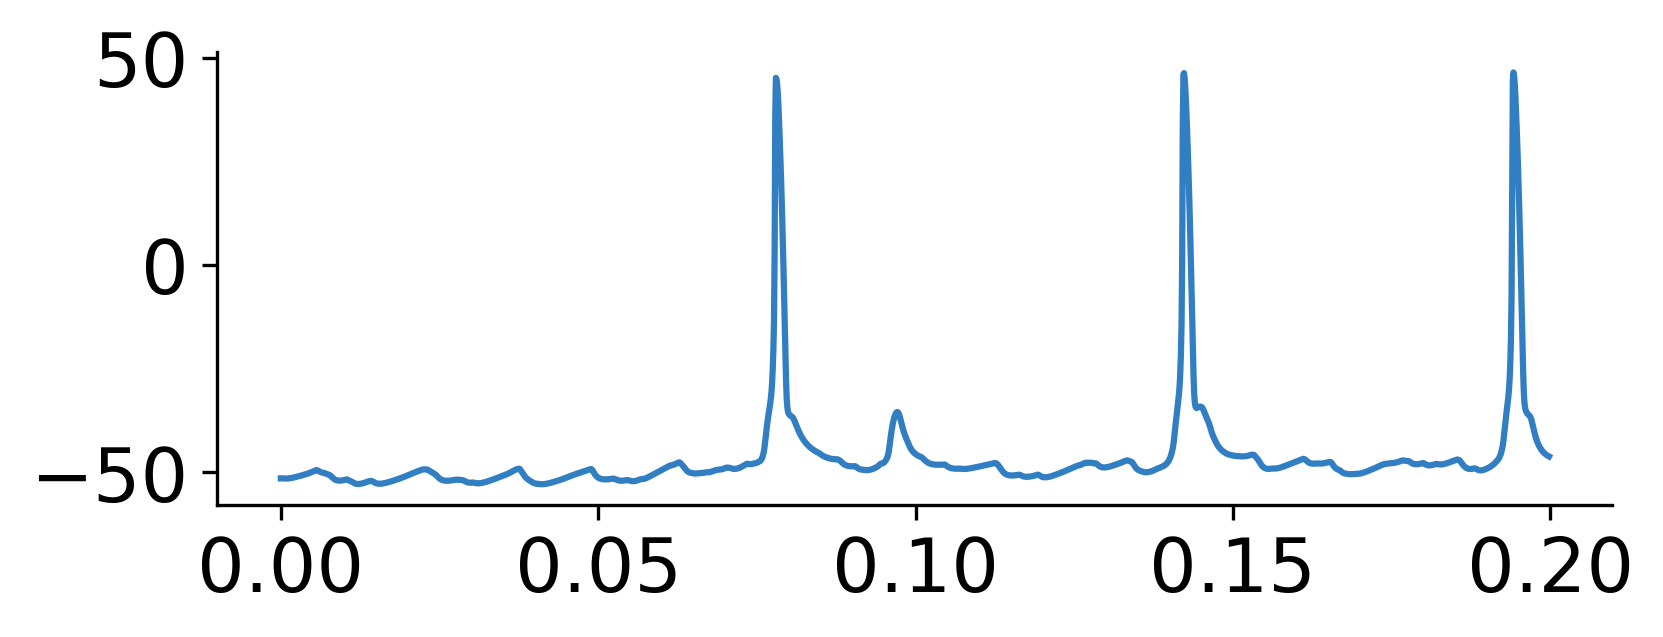

In [53]:
t_vec = np.asarray(t_vec)
s = np.where(t_vec > time_for_single_lap*19+500+1200)[0][0]
e = np.where(t_vec < time_for_single_lap*19+500+1400)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(6,2), dpi=300)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., list(exc_v_vecs[66])[s:e], color=(49/255., 126/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

3184


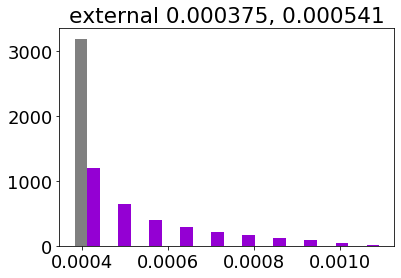

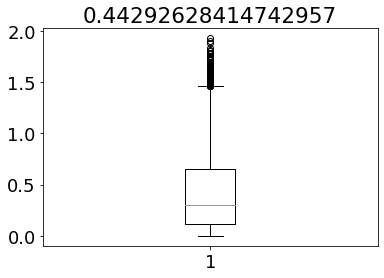

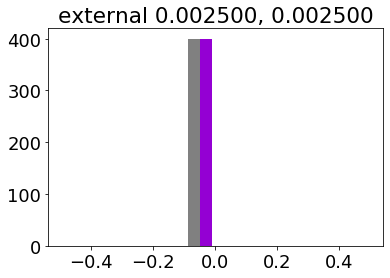

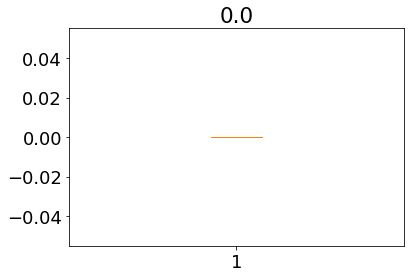

0.014035860644996413


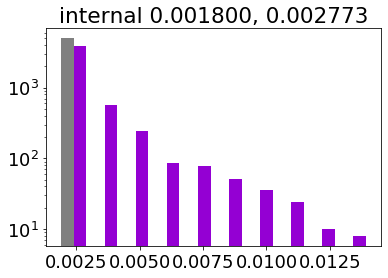

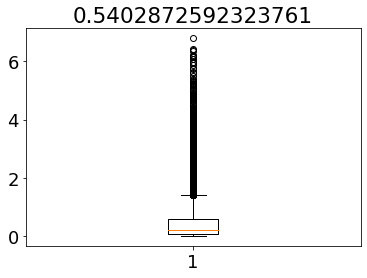

internal 0
0.5698844114432148


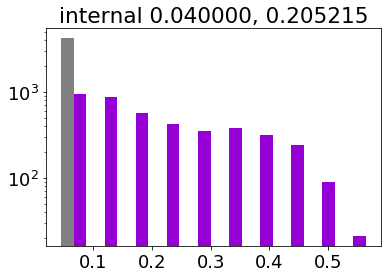

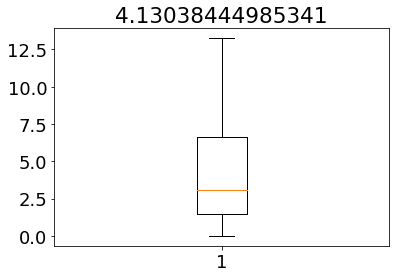

In [49]:
from analysis_utils import external_weight_change, internal_weight_change


external_before, external_after, external_pchange = external_weight_change(circuit, 100, 0)
external_pchange = np.asarray(external_pchange)
print(len(external_after))

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#

external_before, external_after, external_pchange = external_weight_change(circuit, 102, 0)
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#

scale = 2

internal_before, internal_after, internal_pchange = internal_weight_change(circuit, 0, 0, valid_gids=np.arange(130*scale))
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

print('internal', len(np.where(np.asarray(internal_after) >= 0.025)[0]))

#

internal_before, internal_after, internal_pchange = internal_weight_change(circuit, 0, 1, valid_gids=np.arange(130*scale))
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

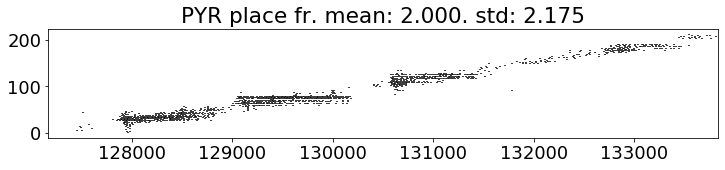

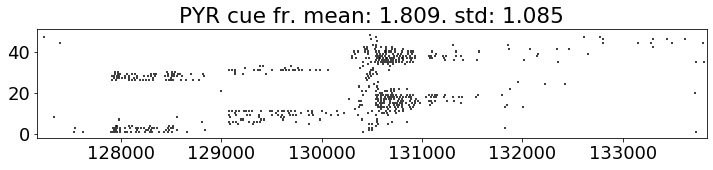

In [53]:
def plot_spikes(c, population_id, title, start, finish, gids=None):
    
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids: temp_spike_times.append(spike_times[i])
        spike_times = temp_spike_times
        
    frs = []
    plt.figure(figsize=(12,2))
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        plt.vlines(np.asarray(sts), i+0.5, i+1.5)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    plt.xlim([start, finish])
    plt.title('%s fr. mean: %0.3f. std: %0.3f' % (title, np.mean(frs), np.std(frs)))
    plt.show()
    return

start  = time_for_single_lap * 19. + 500
finish = time_for_single_lap * 20. + 500
plot_spikes(circuit, 0, 'PYR place', start, finish, gids=diagram.place_information[0]['place'])
plot_spikes(circuit, 0, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'])
#plot_spikes(circuit, 0, 'exa,ple cue', start, finish, gids=[cue_cells[4]])

#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130*2))
#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=None)

    

67
place-cue corr (0.5046414259163261, 1.3335311001210989e-05)
place-pvbc corr (0.8947052411363666, 1.9447117833804724e-24)
pvbc-cue corr (0.4257845979622245, 0.0003279003725319643)


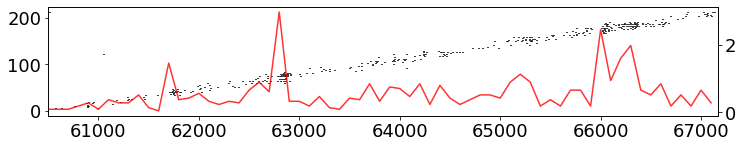

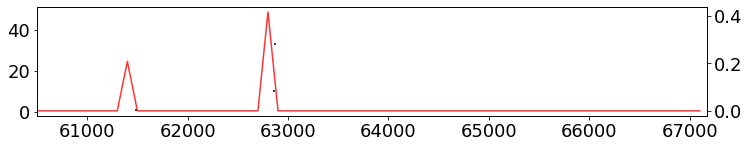

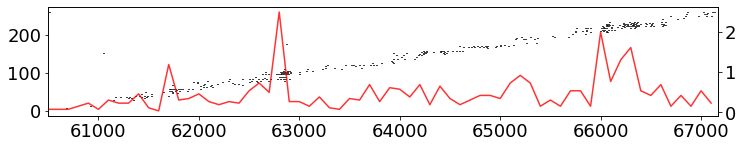

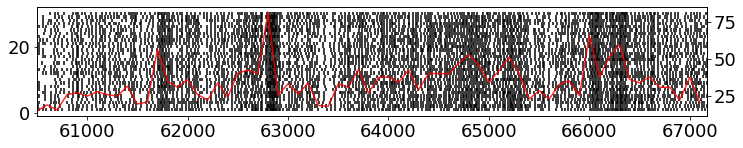

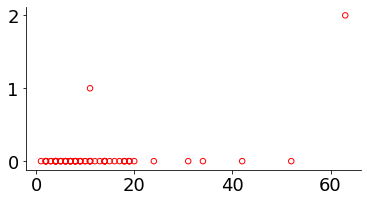

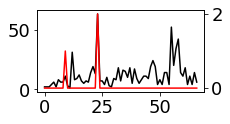

r,p 0.1879876861441682 0.12765732252717266


In [40]:
def plot_spikes(c, population_id, title, start, finish, gids=None, color='k'):
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(spike_times[i])
        spike_times = temp_spike_times
    else:
        gids = np.arange(len(spike_times))
        
    frs = []
    fig, ax = plt.subplots(figsize=(12,2))
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=color)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    ax.set_xlim([start, finish])
    #ax.set_title('%s fr: %0.3f' % (title, np.mean(frs)))
    
    ax2 = ax.twinx()
    
    tick = start
    # jump
    jump = 100 #50ms hops
    nspikes = []
    while tick < finish:
        curr_nspikes = 0
        for (i,sts) in enumerate(spike_times):
            tick_end = tick + jump
            sts = np.asarray(sts)
            sts_chop = sts[np.where( (sts>=tick) & (sts<=tick_end)) [0]]
            curr_nspikes += len(sts_chop)
        tick += jump
        nspikes.append(curr_nspikes)
    nspikes = np.asarray(nspikes)
    avg_fr = (nspikes*1000.)/(jump)/len(gids)
    ax2.plot([start+i*jump for i in range(len(nspikes))],avg_fr, color='r', alpha=0.8)
    #ax2.set_xlim([start, finish])
    return nspikes

start  = time_for_single_lap * 9 + 500
finish = time_for_single_lap * 10 + 500

nspikes_place = plot_spikes(circuit, 0, 'PYR place', start, finish, diagram.place_information[0]['place'])
nspikes_cue   = plot_spikes(circuit, 0, 'PYR cue', start, finish, diagram.place_information[0]['not place'])
nspikes_total = plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130*2))
nspikes_pvbc  = plot_spikes(circuit, 1, 'PVBC', start, finish)



from scipy.stats import pearsonr, spearmanr
print(len(nspikes_place))
print('place-cue corr', pearsonr(nspikes_place, nspikes_cue))
print('place-pvbc corr', pearsonr(nspikes_place, nspikes_pvbc))
print('pvbc-cue corr', pearsonr(nspikes_pvbc, nspikes_cue))

#(6,3)
fig = plt.figure(figsize=(6,3))
ax  = fig.gca()
plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='red',s=30)
# plt.xlabel('number place cells spikes')
# plt.ylabel('number cue cells spikes')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

fig, ax = plt.subplots(figsize=(3,1.5))
ax.plot(nspikes_place, color='k')
ax2 = ax.twinx()
ax2.plot(nspikes_cue, color='r')
plt.show()

from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(nspikes_place, nspikes_cue)
print('r,p', r, p)

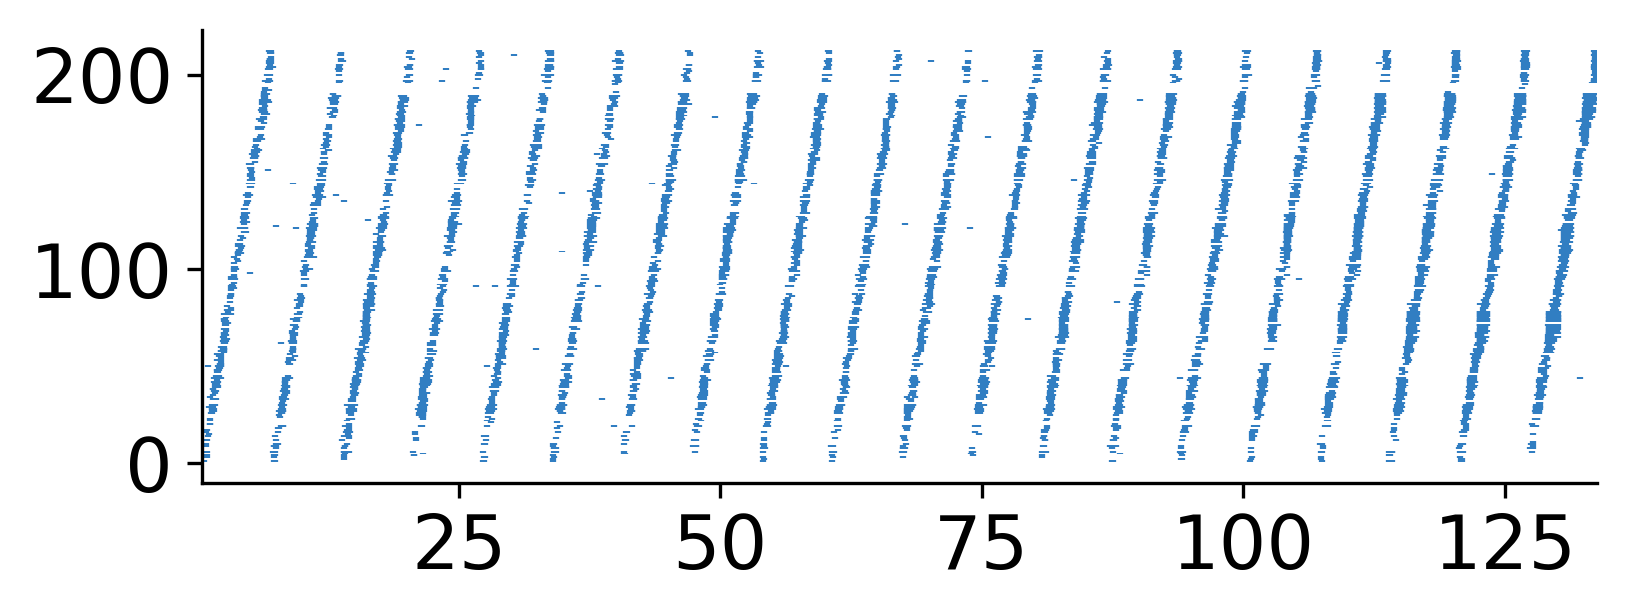

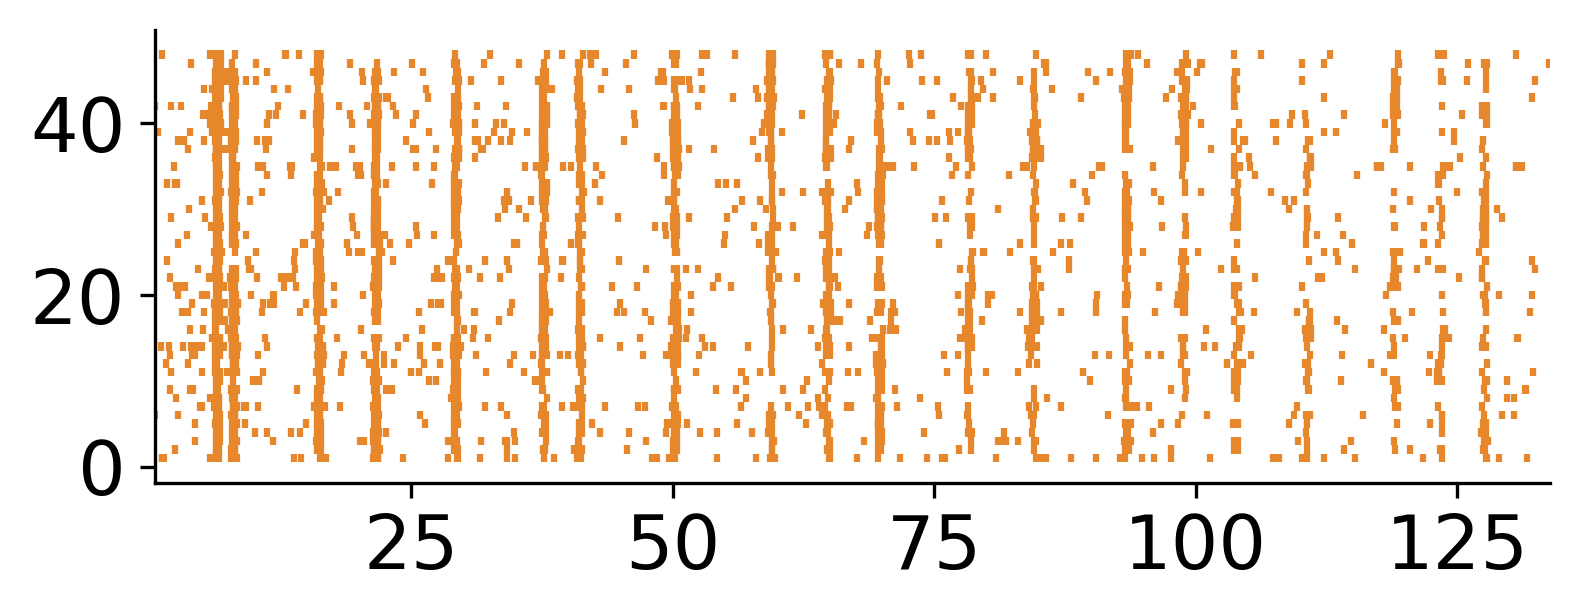

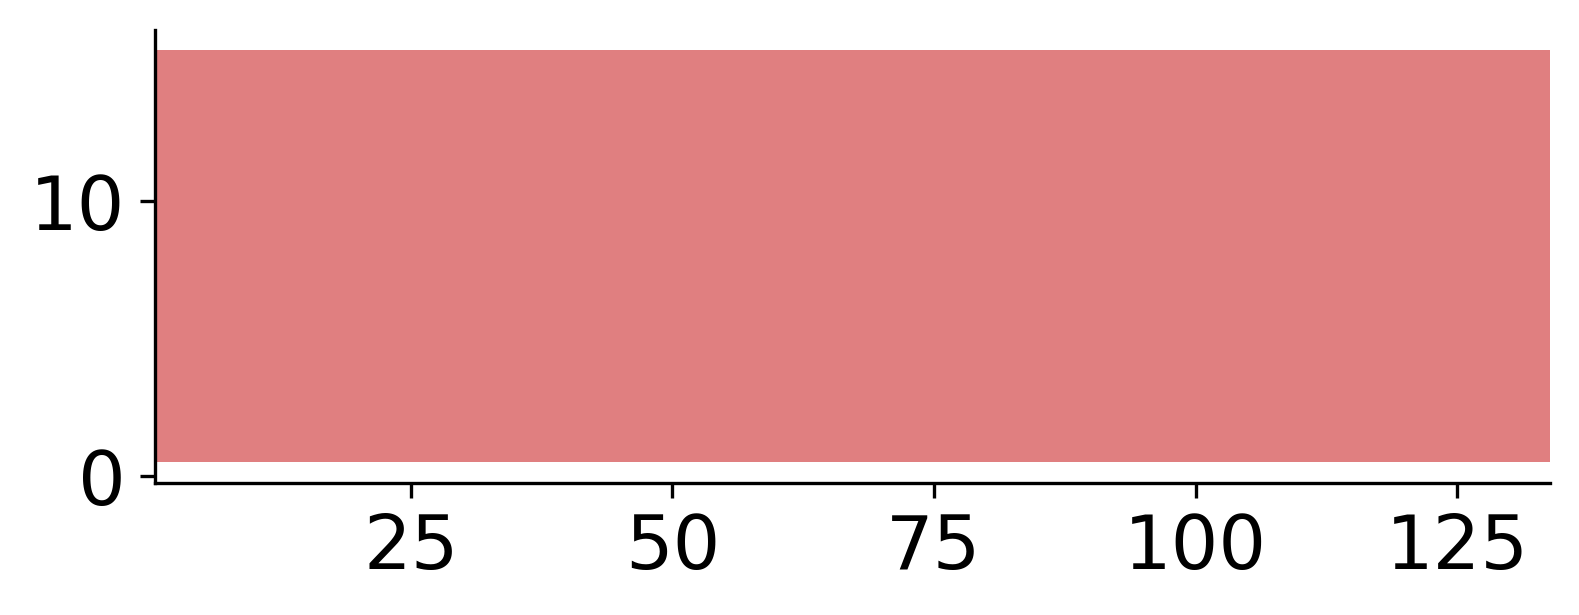

In [58]:
def plot_spikes(c, population_id, title, start, finish, gids=None, color='k'):
    
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids: temp_spike_times.append(np.divide(spike_times[i],1000.))
        spike_times = temp_spike_times
        
    frs = []
    fig = plt.figure(figsize=(6,2), dpi=300)
    ax = fig.gca()
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        plt.vlines(np.asarray(sts), i+0.5, i+1.5, color=color)
        sts_chop = sts[np.where( (sts>=start/1000.) & (sts<=finish/1000.)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    plt.xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)
    #plt.title('%s fr: %0.3f' % (title, np.mean(frs)))
    plt.show()
    
    
#     fig = plt.figure(figsize=(4,2), dpi=300)
#     ax = fig.gca()
#     plt.hist(frs)
#     plt.show()
    
    
    return

start  = time_for_single_lap * 0. + 500
finish = time_for_single_lap * 20. + 500

plot_spikes(circuit, 0, 'PYR place', start, finish, gids=diagram.place_information[0]['place'], color=(49/255.,126/255.,194/255.))
plot_spikes(circuit, 0, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'], color=(231/255.,135/255.,43/255.))
#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130))
plot_spikes(circuit, 1, 'PVBC', start, finish, gids=np.arange(15), color=(224/255.,127/255., 128/255.))

#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=np.arange(130,145))

# plot_spikes(circuit, 2, 'AAC', start, finish)
# plot_spikes(circuit, 3, 'BiS', start, finish)
# plot_spikes(circuit, 4, 'OLM', start, finish)
# plot_spikes(circuit, 5, 'ISCCR', start, finish)
    

2.0535336404085665 0.0420574032112147


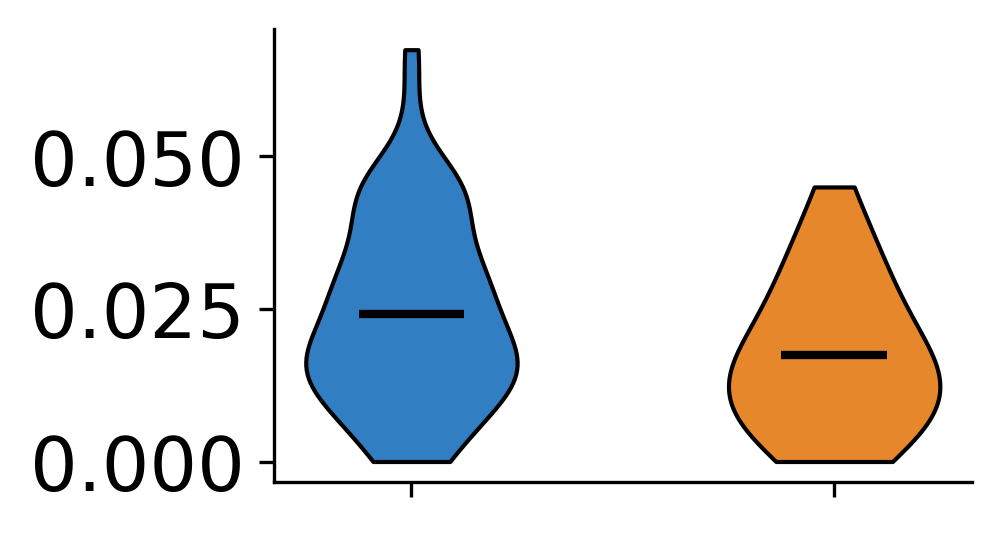

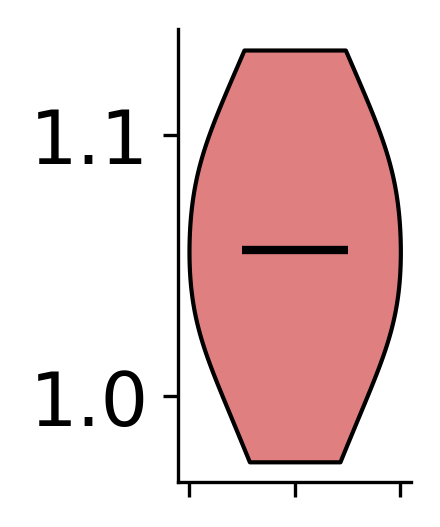

In [149]:
from scipy.stats import ttest_ind

def get_pop_frs(c, population_id, title, start, finish, gids=None, color='k'):
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids: temp_spike_times.append(np.divide(spike_times[i],1000.))
        spike_times = temp_spike_times
        
    frs = []
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        sts_chop = sts[np.where( (sts>=start/1000.) & (sts<=finish/1000.)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        
    return frs

start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

colors = [(49/255.,126/255.,194/255.), (231/255.,135/255.,43/255.), (224/255.,127/255., 128/255.)]

place_frs = get_pop_frs(circuit, 0, 'PYR place', start, finish, gids=diagram.place_information[0]['place'], color=(49/255.,126/255.,194/255.))
cue_frs   = get_pop_frs(circuit, 0, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'], color=(231/255.,135/255.,43/255.))
int_frs   = get_pop_frs(circuit, 1, 'PVBC', start, finish, gids=np.arange(0,15))

t, p = ttest_ind(place_frs, cue_frs)
print(t,p)

fig = plt.figure(dpi=300, figsize=(3,2))
ax = fig.gca()
vplot = plt.violinplot([place_frs, cue_frs], showextrema=False, showmeans=True, positions=[0,1])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

#####
colors = [(224/255.,127/255., 128/255.)]

fig = plt.figure(dpi=300, figsize=(1,2))
ax = fig.gca()
vplot = plt.violinplot([int_frs], showextrema=False, showmeans=True, positions=[0])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

In [28]:
place_cells = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
non_place_cells = diagram.place_information[0]['not place']
scale = 2

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130*scale and presynaptic_gid < 145*scale:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_to_place_weights.append(weight)

pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130*scale and presynaptic_gid < 145*scale:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_to_notplace_weights.append(weight) 
            
print(len(pvbc_to_place_weights) + len(pvbc_to_notplace_weights))
        
fig = plt.figure()
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=['silver', 'darkviolet'], 
         density=True, edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

print('place mean', np.mean(pvbc_to_place_weights))
print('nonplace mean', np.mean(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind, mannwhitneyu
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

u, p2 = mannwhitneyu(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(u, p2)

IndexError: NetCon[14806].weight

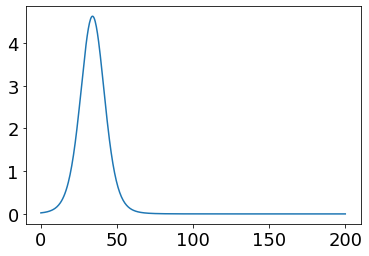

[]

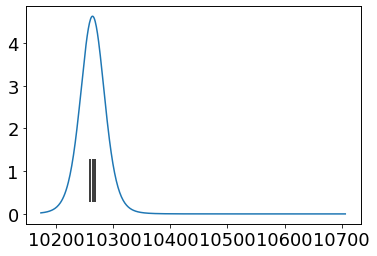

In [51]:
all_exc_frs = []
all_exc_spikes = []
valid_gids = []
start_time = time_for_single_lap * 19 + 500
end_time   = time_for_single_lap * 20 + 500

#for i in circuit.neurons[0].keys():
for (pos,i) in enumerate(place_cells):
    exc_spikes = np.asarray(circuit.neurons[0][i].spike_times)

    time_idxs = np.where( (exc_spikes >= start_time) & (exc_spikes <= end_time))[0]
    exc_spikes = exc_spikes[time_idxs]
    all_exc_spikes.append(exc_spikes)
    step = 12.5 # ms
    estimated_times = np.arange(start_time, end_time, step=step)
    if len(exc_spikes) == 0:
        all_exc_frs.append(np.zeros_like(estimated_times))
    else:
        estimated_fr,_ = baks(exc_spikes/1000., estimated_times/1000., a=10.0) # 1.75?
        all_exc_frs.append(estimated_fr)
        valid_gids.append(pos)

all_exc_frs = np.asarray(all_exc_frs, dtype='float32')

idx = 30
plt.figure()
#plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[valid_gids[idx]])
plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[idx])
plt.show()

fig, ax = plt.subplots()
ax.plot(estimated_times/step, all_exc_frs[idx])
ax2 = ax.twinx()
#ax2.vlines(all_exc_spikes[valid_gids[idx]]/step, 0.5, 1.5)
ax2.vlines(all_exc_spikes[idx]/step, 0.5, 1.5)

ax2.set_ylim([0, 5])
ax2.set_yticks([])


12.745441 12.864575


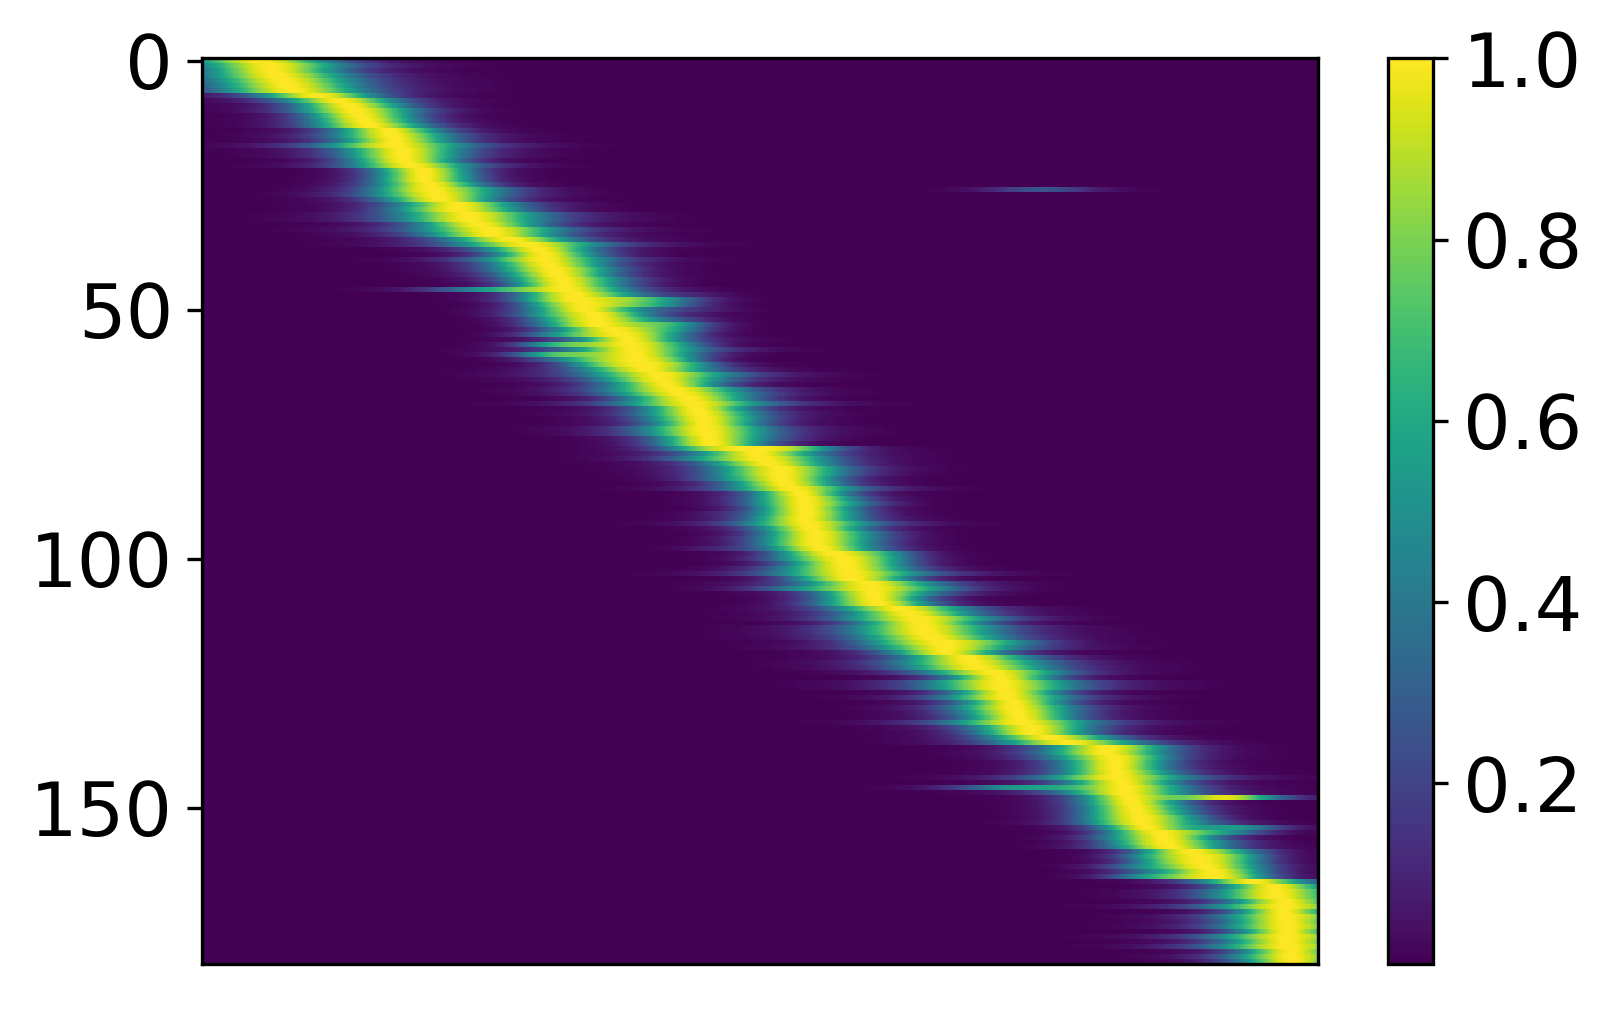

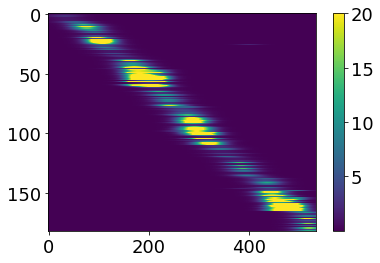

{0, 1, 2}


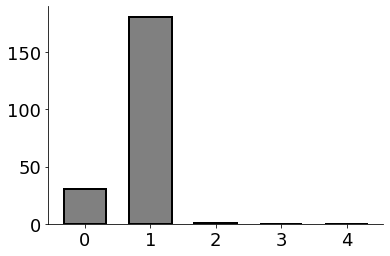

IndexError: index 186 is out of bounds for axis 0 with size 182

In [60]:


# valid_idxs = []
# invalid_idxs = []
# for i in range(len(all_exc_frs)):
#     sl = all_exc_frs[i]
#     if not np.all(sl < 10.0): valid_idxs.append(i)
#     else: 
#         invalid_idxs.append(i)


#valid_idxs = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
#valid_exc_frs = all_exc_frs[valid_idxs,:] # flip a rooni
valid_exc_frs = all_exc_frs[valid_gids]
max_frs = valid_exc_frs.max(axis=1)
print(max_frs.mean(), max_frs.std())


normed = []
for i in range(len(valid_exc_frs)):
    normed.append(valid_exc_frs[i] / valid_exc_frs[i].max())
normed = np.asarray(normed, dtype='float32')

whereismax = []
for i in range(len(normed)):
    sl = normed[i,:]
    whereismax.append(sl.argmax())
sorted_max = np.argsort(whereismax)

normed_sorted        = normed[sorted_max,:]
valid_exc_frs_sorted = valid_exc_frs[sorted_max,:]


plt.figure(dpi=300)
plt.imshow(normed_sorted, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xticks([])
plt.show()

plt.figure()
plt.imshow(valid_exc_frs_sorted, cmap='viridis', aspect='auto', vmax=20)
plt.colorbar()
plt.show()





# fig, ax = plt.subplots(5, 5, figsize=(12,8))
# for i in range(25):
#     xx = int(i/5)
#     yy = int(i%5)
#     ax[xx,yy].plot(estimated_times, normed_sorted[i])
#     ax[xx,yy].hlines(0.80, estimated_times[0], estimated_times[-1], linestyle='--')
#     ax[xx,yy].set_title(i)
    
ncrossed = []
for i in range(len(valid_exc_frs_sorted)):
    sl = normed_sorted[i]
    crossed = False
    ticks = 0
    for s in sl:
        if s > 0.80 and not crossed: 
            crossed = True
            ticks += 1
        if s <= 0.80 and crossed:
            crossed = False
    ncrossed.append(ticks)

ncrossed = np.asarray(ncrossed + [0 for _ in range(len(all_exc_frs) - len(valid_exc_frs))])
print(set(ncrossed))
fig = plt.figure()
ax = fig.gca()
plt.hist(ncrossed, bins=[0,1,2,3,4,5], align='left', rwidth=0.65, 
         edgecolor='k', color='gray', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

spike_times = np.asarray(circuit.get_cell_spikes(0))[valid_gids]
valid_raster = []
for nid in np.asarray(valid_idxs)[sorted_max]:
    valid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(valid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


invalid_raster = []
for nid in invalid_idxs:
    invalid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(invalid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259]


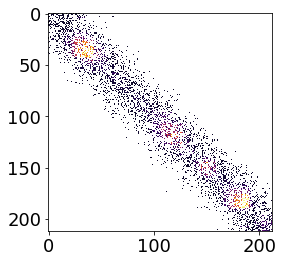

In [21]:
# weight matrix
def create_adj_matrix(circuit, src_cells, dst_cells):
    Nsrc = len(src_cells)
    Ndst = len(dst_cells)
    adj_matrix = np.zeros((Ndst,Nsrc), dtype='float32')
    
    for (cidx, cell) in enumerate(dst_cells):
        presynaptic_inputs = circuit.neurons[0][cell].internal_netcons
        for presynaptic_gid, nc, _ in presynaptic_inputs:
            if presynaptic_gid not in src_cells: continue
            try:
                pre_loc = list(src_cells).index(presynaptic_gid)
            except:
                continue
            nc = nc[0]
            weight = nc.weight[0] + nc.weight[1]
            
            adj_matrix[cidx, pre_loc] = weight
    return adj_matrix

place_cells = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
cue_cells = diagram.place_information[0]['not place']
print(place_cells)
adj_matrix = create_adj_matrix(circuit, place_cells, place_cells)
valid_vals = []
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i,j] > 0.0: valid_vals.append(adj_matrix[i,j])
cutoff = np.percentile(valid_vals, 0.)
adj_matrix[adj_matrix <= cutoff] = None



plt.figure(figsize=(4,4))
plt.imshow(adj_matrix, cmap='inferno', vmin=0.000, aspect='auto', vmax=0.0250)
# plt.xlabel('presynaptic')
# plt.ylabel('postsynaptic')
#plt.colorbar()
plt.show()



In [54]:
def save_parameters(circ, save_filepath):
    complete_weights = {}
    for population_gid in circ.neurons.keys():
        if population_gid == 'Septal': continue
        complete_weights[str(population_gid)] = None
        cell_info_to_save = []
        population_info = circ.neurons[population_gid]
        for cell_gid in population_info.keys():
            cell_info = population_info[cell_gid]
            for (presynaptic_id, nc, _) in cell_info.internal_netcons:
                for netcon in nc:
                    cell_info_to_save.append(netcon.weight[0])
                    if len(netcon.weight) == 3:
                        cell_info_to_save.append(netcon.weight[1])
                    else: cell_info_to_save.append(0.0)
            for external_id in cell_info.external_netcons.keys():
                external_cell_info = cell_info.external_netcons[external_id]
                for (idx,(presynaptic_gid, nc, compartment)) in enumerate(external_cell_info):
                    for netcon in nc:
                        cell_info_to_save.append(netcon.weight[0])
                        if len(netcon.weight) == 3: 
                            cell_info_to_save.append(netcon.weight[1])
                        else: cell_info_to_save.append(0.0)
        complete_weights[str(population_gid)] = cell_info_to_save
        print(len(cell_info_to_save))
    
    #np.savez(save_filepath, frs=all_exc_frs, spikes=all_exc_spikes, valid_gids=valid_gids, **complete_weights)
    np.savez(save_filepath, **complete_weights)

save_parameters(circuit, 'models/9622-cue-ee-ei-nlaps-15-dt-zerodot1-scale-2-v1.npz')

241600
59040


place median nan
nonplace median nan
nan nan


/home/dhh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


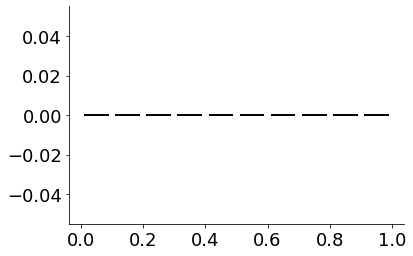

In [89]:
# motif analysis on place and non-place fields
# place_cells = place_cells
non_place_cells = diagram.place_information[0]['not place']
place_cells = diagram.place_information[0]['place']

pvbc_gids = np.arange(130, 145)

place_weights, nonplace_weights = [], []
for pvbc_gid in circuit.neurons[1].keys():
    pvbc_info = circuit.neurons[1][pvbc_gid].internal_netcons
    for (presynaptic_gid, nc, _) in pvbc_info:
        if presynaptic_gid in place_cells:
            try:
                weight = nc[0].weight[0] + nc[0].weight[1]
                place_weights.append(weight)
            except: continue
        elif presynaptic_gid in non_place_cells:
            try:
                weight = nc[0].weight[0] + nc[0].weight[1]
                nonplace_weights.append(weight)
            except: continue
                
fig = plt.figure()
ax  = fig.gca()
plt.hist([place_weights, nonplace_weights], color=['silver', 'darkviolet'], edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(place_weights))
print('nonplace median', np.median(nonplace_weights))

from scipy.stats import ttest_ind
t, p = ttest_ind(place_weights, nonplace_weights)
print(t, p)

place median 0.004017610627712077
nonplace median 0.004010185080427599
9.245959732972235 9.270688088888291e-20


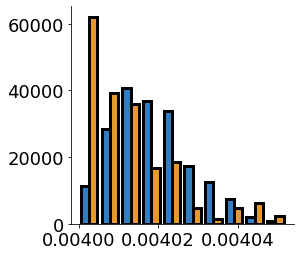

In [19]:
non_place_cells = diagram.place_information[0]['not place']
place_cells = diagram.place_information[0]['place']

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130 and presynaptic_gid < 145:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_to_place_weights.append(weight)

pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130 and presynaptic_gid < 145:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_to_notplace_weights.append(weight)      
        
fig = plt.figure(figsize=(4,4))
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)], 
         density=True, edgecolor='k', linewidth=3)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

[0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]


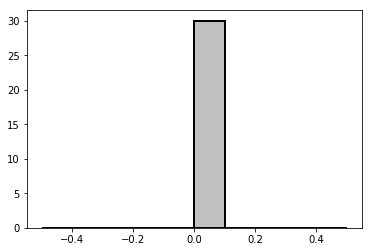

In [210]:
pvbc_gids = np.arange(130, 145)
pvbc_recurrent_weights = []
for pvbcgid in np.arange(0,15):
    cell_info = circuit.neurons[1][pvbcgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid in pvbc_gids:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_recurrent_weights.append(weight)

            
print(pvbc_recurrent_weights)
plt.figure()
plt.hist([pvbc_recurrent_weights], color=['silver'], edgecolor='k', linewidth=2)
plt.show()